In [1]:
import pickle
from dataclasses import asdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
import seaborn as sns

from cardiac_electrophysiology.ulac import parameterization, preprocessing

In [2]:
patient_id = "01"
infile_name = f"../data/processed/patient_{patient_id}/mesh_with_fibers_tags.vtk"
load_file = Path("segmentation.pkl")
save_file = Path("parameterization.pkl")

vtk_mesh = pv.read(infile_name)
triangular_mesh = preprocessing.convert_unstructured_to_polydata_mesh(vtk_mesh)
with load_file.open("rb") as f:
    boundary_paths, pv_markers, laa_markers, mv_markers = pickle.load(f)

In [3]:
parameterized_pv_paths = parameterization.parameterize_pv_paths_by_arc_length(
    triangular_mesh, boundary_paths, pv_markers
)
parameterized_laa_path = parameterization.parameterize_laa_path_by_arc_length(
    triangular_mesh, boundary_paths, laa_markers
)
parameterized_mv_path = parameterization.parameterize_mv_path_by_arc_length(
    triangular_mesh, boundary_paths, mv_markers
)

In [4]:
uac_specs = parameterization.UACSpecs(
    alpha_min=0.0,
    alpha_max=1.0,
    beta_min=0.0,
    beta_max=1.0,
    relative_center_lipv = (2/3, 2/3),
    relative_center_lspv = (2/3, 1/3),
    relative_center_ripv = (1/3, 2/3),
    relative_center_rspv = (1/3, 1/3),
    radius_pv_inner=0.1,
    radius_pv_outer=0.05,
    radius_laa=0.1,
)

uac_pv_boundaries = parameterization.compute_uac_pv_boundaries(parameterized_pv_paths, uac_specs)
uac_laa_boundary = parameterization.compute_uac_laa_boundary(parameterized_laa_path, uac_specs)
uac_mv_boundary = parameterization.compute_uac_mv_boundary(parameterized_mv_path, uac_specs)

In [5]:
uac_to_visualize = "alpha"

plotter = pv.Plotter(window_size=[600, 600])
plotter.add_mesh(
    triangular_mesh,
    style="wireframe",
    color="lightgray",
)
# for boundary in asdict(uac_pv_boundaries).values():
#     path_points = pv.PolyData(triangular_mesh.points[boundary["inds"]])
#     path_points.point_data["alpha"] = boundary["alpha"]
#     path_points.point_data["beta"] = boundary["beta"]
#     plotter.add_points(path_points, scalars=uac_to_visualize, point_size=10, render_points_as_spheres=True)

path_points = pv.PolyData(triangular_mesh.points[uac_pv_boundaries.RSPV_outer.inds])
start_point = pv.PolyData(triangular_mesh.points[uac_pv_boundaries.RSPV_outer.inds[0]])
path_points.point_data["alpha"] = uac_pv_boundaries.RSPV_outer.alpha
plotter.add_points(path_points, scalars="alpha", point_size=10, render_points_as_spheres=True)
plotter.add_points(start_point, color="red", point_size=15, render_points_as_spheres=True)

path_points = pv.PolyData(triangular_mesh.points[uac_mv_boundary.inds])
path_points.point_data["alpha"] = uac_mv_boundary.alpha
path_points.point_data["beta"] = uac_mv_boundary.beta
#plotter.add_points(path_points, scalars=uac_to_visualize, point_size=10, render_points_as_spheres=True)
plotter.show()

Widget(value='<iframe src="http://localhost:36019/index.html?ui=P_0x7f418c8d6270_0&reconnect=auto" class="pyvi…

In [6]:
objects_to_save = [uac_pv_boundaries, uac_laa_boundary, uac_mv_boundary]

with save_file.open("wb") as f:
    pickle.dump(objects_to_save, f)

Text(0, 0.5, '$\\beta$')

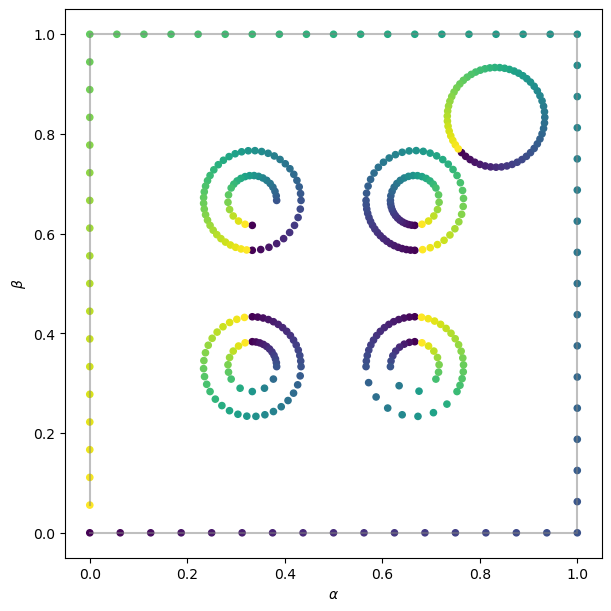

In [7]:
_, ax = plt.subplots(figsize=(6, 6), layout="constrained")
ax.plot(uac_mv_boundary.alpha, uac_mv_boundary.beta, color="grey", alpha=0.5)
plt.scatter(
    uac_pv_boundaries.RIPV_inner.alpha,
    uac_pv_boundaries.RIPV_inner.beta,
    c=parameterized_pv_paths.RIPV_inner.relative_length,
    cmap="viridis",
    s=20,
)
plt.scatter(
    uac_pv_boundaries.RIPV_outer.alpha,
    uac_pv_boundaries.RIPV_outer.beta,
    c=parameterized_pv_paths.RIPV_outer.relative_length,
    cmap="viridis",
    s=20,
)
plt.scatter(
    uac_pv_boundaries.RSPV_inner.alpha,
    uac_pv_boundaries.RSPV_inner.beta,
    c=parameterized_pv_paths.RSPV_inner.relative_length,
    cmap="viridis",
    s=20,
)
plt.scatter(
    uac_pv_boundaries.RSPV_outer.alpha,
    uac_pv_boundaries.RSPV_outer.beta,
    c=parameterized_pv_paths.RSPV_outer.relative_length,
    cmap="viridis",
    s=20,
)
plt.scatter(
    uac_pv_boundaries.LIPV_inner.alpha,
    uac_pv_boundaries.LIPV_inner.beta,
    c=parameterized_pv_paths.LIPV_inner.relative_length,
    cmap="viridis",
    s=20,
)
plt.scatter(
    uac_pv_boundaries.LIPV_outer.alpha,
    uac_pv_boundaries.LIPV_outer.beta,
    c=parameterized_pv_paths.LIPV_outer.relative_length,
    cmap="viridis",
    s=20,
)
plt.scatter(
    uac_pv_boundaries.LSPV_inner.alpha,
    uac_pv_boundaries.LSPV_inner.beta,
    c=parameterized_pv_paths.LSPV_inner.relative_length,
    cmap="viridis",
    s=20,
)
plt.scatter(
    uac_pv_boundaries.LSPV_outer.alpha,
    uac_pv_boundaries.LSPV_outer.beta,
    c=parameterized_pv_paths.LSPV_outer.relative_length,
    cmap="viridis",
    s=20,
)
plt.scatter(
    uac_laa_boundary.alpha,
    uac_laa_boundary.beta,
    c=parameterized_laa_path.relative_length,
    cmap="viridis",
    s=20,
)
plt.scatter(
    uac_mv_boundary.alpha,
    uac_mv_boundary.beta,
    c=parameterized_mv_path.relative_length,
    cmap="viridis",
    s=20,
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\beta$")